# Single Compartment Neural Models Notes and Homework

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Overview

We now consider the effect of gated channels on ion flow. Each channel contains a series of gates, 4 in the case of potassium, and 3+1 for sodium.  All of these gates must be open for the channel to conduct.  We imagine the gates to be controlled by a markov process with transition coefficients that depend on the membrane potential.  These transitions reach an equilibrium for a set voltage with timescales of $.1-1ms$ which is fast compared to most membrane dynamics.  Hodgkin and Huxley realized that by having gates that "turned on" (and off) at different voltages, we can generate action potentials.  The process is as follows:

1. At rest we have mostly potassium flow out of the cell countering a leak current.
2. As the potential rises, the sodium current turns on first, quickly pulling the membrane potential up (these are the 3 gates in the 3+1)
3. As the potential rises the other gate in sodium whose equilibrium value is a decreasig function of voltage begins to turn off, abruptly cutting off the flow of sodium and allow potassium to restore the cell to its resting potential

It is also worth noting that this occurs only at the thin border of the membrane and the number of ions that flow across is a small fraction of the total in the bulk.  The cell is "charged" enough to give many action potentials without the operation of its ion pumps and the dynamics occur only along the membrane.

### Ion Gated Channels

Ion exchange through a membrane is mediated by channels whose flow is controlled by a set of gates.  These are depicted below
<img src='images/hh_gate_image.jpeg'>

HH found that their data was best fit by including 4 gating variables in the potassium channels and 3 fast and 1 slow gating variables in the sodium channels.  The meaning of fast and slow will become clear later.  The gates are essentially like little doors that, all of which must be open in a given channel in order for current to flow.  As the gate's transition rates vary with the membrane potential, they can give positive/negative feedback to changes and give rise to interesting dynamics.

### Channel Gate Dynamics

We can consider a single gate's state to be a stochastic variable (which can be either open or closed, or 1 or 0).  Across a whole neuron, we consider the fraction of gates open and closed and by the CLT this smooths our dynamics.  Defining $n$ as the fraction of open gates, $\alpha_n$ as the opening rate and $\beta_n$ as the closing rate, we then have, in the continuum limit,
$$\frac{dn}{dt} = \alpha_n(V_m) (1-n) - \beta_n(V_m)n.$$
We rearrange this to clarify the meaning of some terms:
$$\tau_n\frac{dn}{dt} = n_\infty(V_m) - n$$
which gives a timescale $\tau_n = \frac{1}{\alpha_n + \beta_n}$ and equilibrium value $n_\infty = \frac{\alpha_n}{\alpha_n + \beta_n}$. The solution of this at a particular voltage is simply
$$(n_0 - n_\infty) e^{-t/\tau} + n_\infty$$
so the system exponentially approches the equilibrium value with timescale $\tau$.

The dynamics suggested by this are fairly boring unless $\alpha$ and $\beta$ vary with $V_m$ (why else would you have gone through the work to evolve gates). To get at the form of this dependence, we imagine the gate as a two state system with energies $\epsilon_o$ and $\epsilon_c$ associated with being open or closed respectively. At equilibrium, the two states will occur in proportion to their boltzmann factors: $\frac{n_o}{n_c} = e^{-(\epsilon_o - \epsilon_c)/kT}$.  Similarly, at equilibrium, transitions between the states must preserve this distribution so $\alpha n_c = \beta n_o$ and so we have
$$\frac{\alpha}{\beta} = e^{-(\epsilon_o - \epsilon_c)/kT}$$.

### Exercise problem:

####Experiment setup:

In [23]:
C_m  =   1.0 # membrane capacitance, in uF/cm^2
g_K  =   36.0 # maximum conducances, in mS/cm^2
g_L  =   0.3
g_Na =   120
E_K  =  -82.0
E_L  =  -59.387
E_Na =   45.0

V_s= sp.arange(-90.0 ,70.0, 0.1)


def alpha_m(V): return  0.1 *( V + 45 ) / ( 1 - sp.exp( -(V + 45)/10))
def beta_m(V) : return  4 * sp.exp(-(V + 70)/18)
def alpha_h(V): return  0.07 * sp.exp(-(V + 70)/20)
def beta_h(V) : return  1/(1 + sp.exp(-(V + 40)/10))
def alpha_n(V): return  0.01* (V + 60)/(1 - sp.exp(-(V + 60)/10))
def beta_n(V) : return  0.125 * sp.exp(-(V + 70)/80)

####2.1

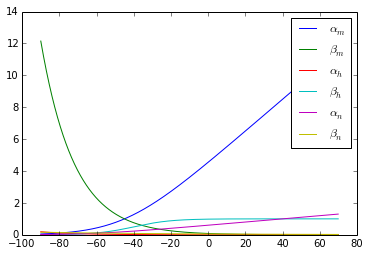

In [24]:
plt.figure()
plt.plot(V_s, alpha_m(V_s), label="$ \\alpha_{m}$")
plt.plot(V_s, beta_m(V_s) , label="$ \\beta_{m}$")  
plt.plot(V_s, alpha_h(V_s), label="$ \\alpha_{h}$")
plt.plot(V_s, beta_h(V_s) , label="$ \\beta_{h}$") 
plt.plot(V_s, alpha_n(V_s), label="$ \\alpha_{n}$")
plt.plot(V_s, beta_n(V_s) , label="$ \\beta_{n}$") 
plt.legend(loc="upper right")

###2.2

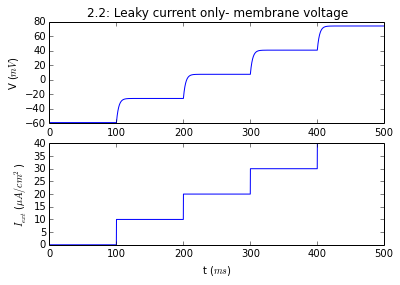

In [46]:
# Membrane currents (in uA/cm^2)
t_start = 0
t_stop = 500
t_step = 0.1
t = sp.arange(t_start, t_stop, t_step)
def I_L(V): return g_L * (V - E_L)
def I_ext(t): return 10*floor(t/100)
	
def stepV_L(V, t):
	dvdt = (I_ext(t)-I_L(V))/C_m
	return dvdt
V_L = odeint(stepV_L, [E_L], t)

plt.figure()
plt.subplot(2,1,1)
plt.title('2.2: Leaky current only- membrane voltage')
plt.ylabel('V ($mV$)')
plot(t, V_L)
plt.subplot(2,1,2)
plot(t, I_ext(t))
plt.ylabel('$I_{ext}$ ($\\mu{A}/cm^2$)')
plt.xlabel('t ($ms$)')


So each $uA$ increases the membrane potential by about 3.5 mV.

###2.3

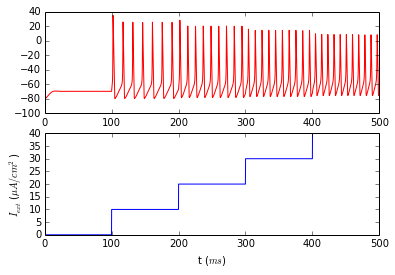

In [47]:

## calculation of m, h, n

def I_K(V, n):  
	return g_K   * n**4          * (V - E_K)
def I_Na(V, m, h):  
	return g_Na  * m**3  *h      * (V - E_Na)	
#def stepV_ALL(V, t, m, h, n):
#	dvdt = (I_ext(t)-I_L(V)-I_Na(V, m, h), -I_K(V, n))/C_m
#	return dvdt
#V_ALL = odeint(stepV_L, [E_L], t, args= (V, m , h, n))
	
def I_ext2(t): return 10*floor(t/100) # injected current 0~200uA
def dALLdt(X,t):
    V, m, h, n= X
    dVdt = (I_ext2(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    dmdt = alpha_m(V)*(1-m)-beta_m(V)*m
    dhdt = alpha_h(V)*(1-h)-beta_h(V)*h
    dndt = alpha_n(V)*(1-n)-beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt
# Call the odeint, giving 2 initial conditions, for V and w, in the same order as everything else
# initial values for  V         m         h        n     NULL

X = odeint(dALLdt, ( -70,  0.3, 0.05, 0.6), t)
V = X[:,0] # the first  column is the V values
m = X[:,1] # the second column is the m values
h = X[:,2] # the second column is the h values
n = X[:,3] # the second column is the n values
plt.figure()
plt.subplot(2,1,2)
plot(t, I_ext2(t))
plt.ylabel('$I_{ext}$ ($\\mu{A}/cm^2$)')
plt.xlabel('t ($ms$)')
plt.subplot(2,1,1)
plot(t, V, 'r-', label='$V$')

We see that the neuron begins spiking wildly after we increase the external current past $10\mu A$ and the frequency of spike grows with the external current, however the amplitude of the spikes begins to decay.  To see what happens when we increase it past $160 \mu A$ we solve the system for a longer time.

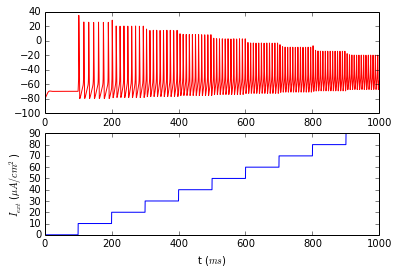

In [48]:
t_start = 0
t_stop = 1000
t_step = 0.1
t = sp.arange(t_start, t_stop, t_step)
X = odeint(dALLdt, ( -70,  0.3, 0.05, 0.6), t)
V = X[:,0] # the first  column is the V values
m = X[:,1] # the second column is the m values
h = X[:,2] # the second column is the h values
n = X[:,3] # the second column is the n values
plt.figure()
plt.subplot(2,1,2)
plot(t, I_ext2(t))
plt.ylabel('$I_{ext}$ ($\\mu{A}/cm^2$)')
plt.xlabel('t ($ms$)')
plt.subplot(2,1,1)
plot(t, V, 'r-', label='$V$')


###2.4

The graph is not so transparent over such a long time scale, but we do see the voltage entering another fixed point around -50mV.  Were we to dial down the current afterwards, we should observe hysteresis. To get an idea of the voltage required to make the neuron spike, we zoom in on the first spike.

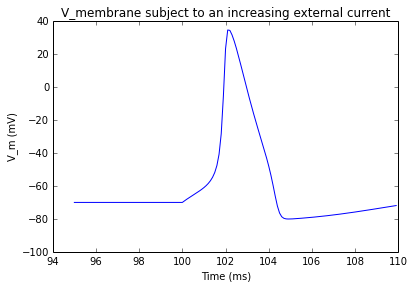

In [49]:
fig6 = plt.figure()
ax6 = fig6.add_axes([0.1, 0.1, 0.8, 0.8])
ax6.plot(t[950:1100], V[950:1100])

ax6.set_xlabel('Time (ms)')
ax6.set_ylabel('V_m (mV)')
ax6.set_title('V_membrane subject to an increasing external current')

It's difficult to tell precisely, but it certainly seems to be on the order of 5-10 mV. The graph seems to turn sharply when the voltage reaches -60mV.

Looking at the transition coefficients, the order of magnitude imbalance between potassium and sodium transition coefficients is responsible for the runaway potential in the spike. By shifting both coefficients for both ions to the right, we should be able to change the point at which this runaway occurs.  This works and I have tested several other modifications, but the dynamics are very sensitive to these and the behavior of the system is drastically different for most modifications. To me, this suggests that these coefficients are highly 'tuned' to keep the system close to some optimal state...